In [16]:
!pip uninstall torch torchvision torchaudio -y
!pip install torch==2.5.1 torchvision torchaudio==2.5.1


Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install torch==2.5.1 and torchvision==0.16.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested torch==2.5.1
    torchvision 0.16.1 depends on torch==2.1.1

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help v

In [2]:
!unzip /content/drive/MyDrive/ColoractalCancer/ColoractalCancer.zip

Streaming output truncated to the last 5000 lines.
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1005.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1006.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1007.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1008.jpeg  
  inflating: lung_c

In [1]:
import os

def print_folder_structure(root_dir, indent=""):
    for item in os.listdir(root_dir):
        path = os.path.join(root_dir, item)
        if os.path.isdir(path):
            print(indent + "|-- " + item)
            print_folder_structure(path, indent + "    ")
        elif not item.lower().endswith(('.jpg', '.jpeg')):
            print(indent + "|-- " + item)

# Usage
print_folder_structure("/content/lung_colon_image_set")


|-- colon_image_sets
    |-- colon_aca
    |-- colon_n
|-- lung_image_sets
    |-- lung_aca
    |-- lung_scc
    |-- lung_n


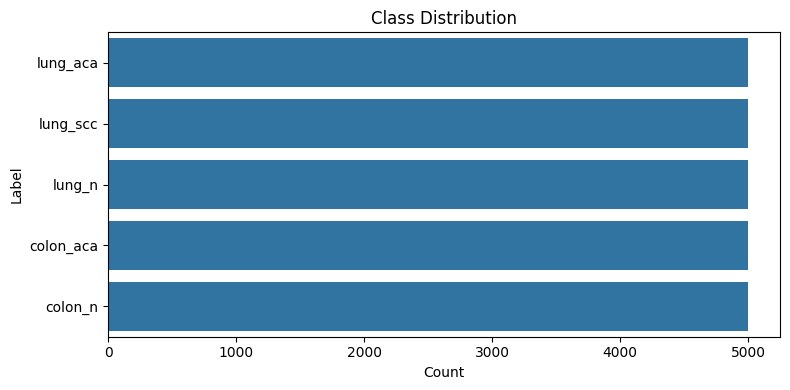

In [2]:
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

# Top-level directory containing both lung and colon folders
data_dir = "/content/lung_colon_image_set"

# Collect all image paths and labels
data = []

# Iterate through both 'lung_image_sets' and 'colon_image_sets'
for tissue_type in ['lung_image_sets', 'colon_image_sets']:
    tissue_path = os.path.join(data_dir, tissue_type)
    for class_name in os.listdir(tissue_path):
        class_path = os.path.join(tissue_path, class_name)
        if os.path.isdir(class_path):
            for img_file in glob(os.path.join(class_path, "*.jpeg")):
                data.append((img_file, class_name))

# Create DataFrame
df = pd.DataFrame(data, columns=["filepath", "label"])

# Show class distribution
plt.figure(figsize=(8, 4))
sns.countplot(data=df, y="label", order=df['label'].value_counts().index)
plt.title('Class Distribution')
plt.xlabel('Count')
plt.ylabel('Label')
plt.tight_layout()
plt.show()


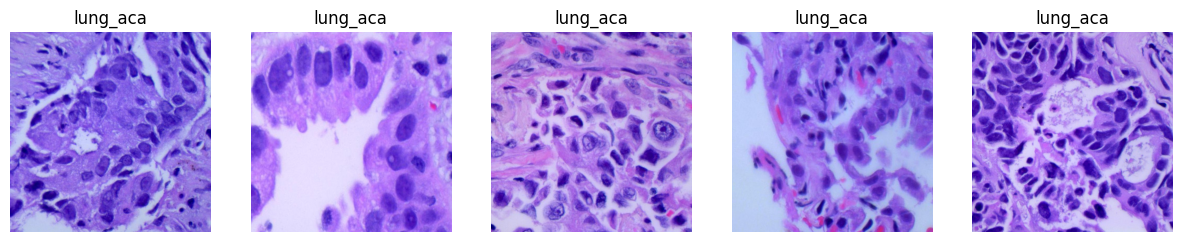

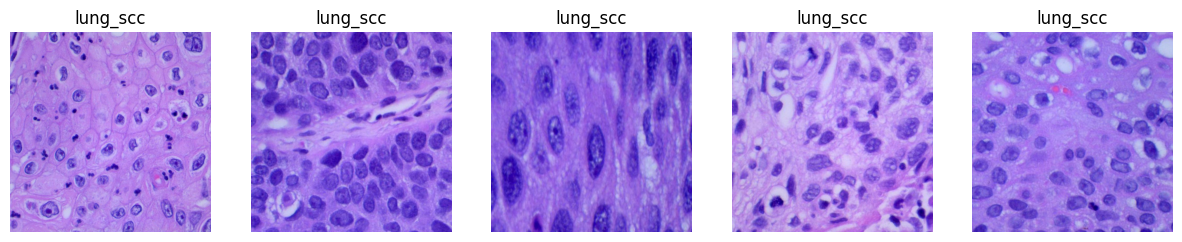

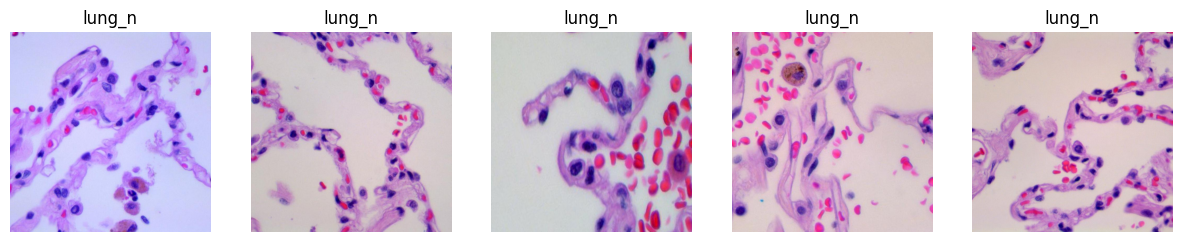

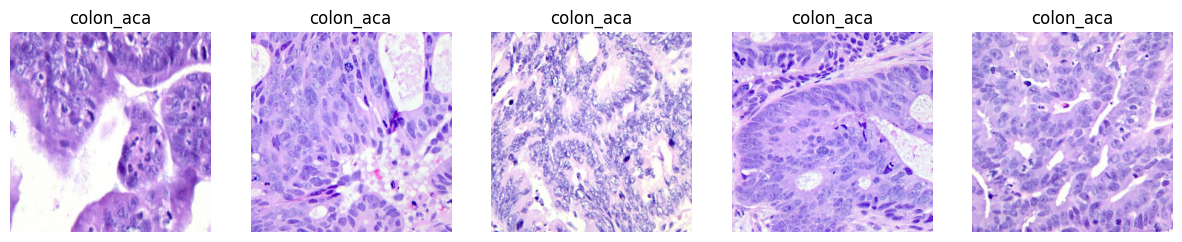

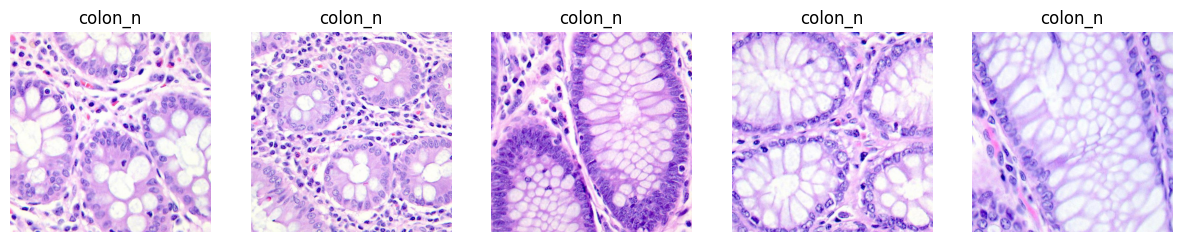

In [17]:
import matplotlib.pyplot as plt

def show_samples(df, class_name, n=5):
    files = df[df['label'] == class_name]['filepath'].sample(n)
    plt.figure(figsize=(15, 3))
    for i, file in enumerate(files):
        img = Image.open(file)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

for label in df['label'].unique():
    show_samples(df, label)


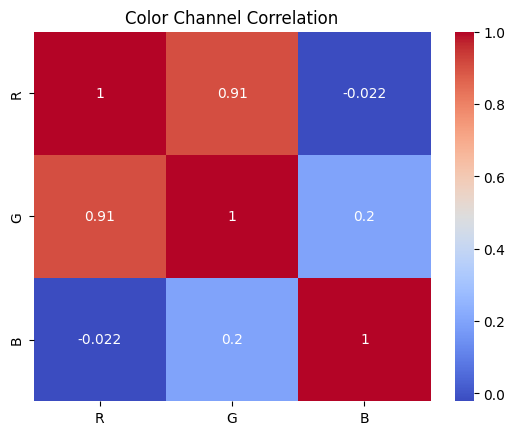

In [18]:
import numpy as np

means = []
for path in df['filepath'].sample(500):  # Limit for speed
    img = np.array(Image.open(path)) / 255.0
    means.append(np.mean(img, axis=(0, 1)))  # per-channel RGB mean

means = np.array(means)
sns.heatmap(pd.DataFrame(means, columns=["R", "G", "B"]).corr(), annot=True, cmap='coolwarm')
plt.title("Color Channel Correlation")
plt.show()


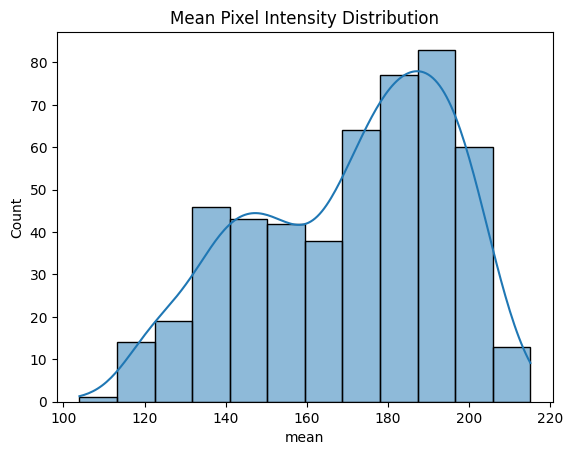

In [3]:
# Example: compute mean pixel intensity for a random sample
sample_imgs = df.sample(500)

def get_img_stats(img_path):
    img = Image.open(img_path).convert('L')
    img_arr = np.array(img)
    return {
        "mean": img_arr.mean(),
        "std": img_arr.std(),
        "min": img_arr.min(),
        "max": img_arr.max()
    }

stats = pd.DataFrame([get_img_stats(f) for f in sample_imgs['filepath']])
sns.histplot(stats['mean'], kde=True).set(title="Mean Pixel Intensity Distribution")
plt.show()


In [6]:
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms

# Label Encoding
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Define image transforms (PyTorch)
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # or 256, 299 depending on the model
    transforms.ToTensor(),          # converts to [0,1]
    transforms.Normalize([0.5]*3, [0.5]*3)  # simple normalization
])


In [19]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch

class SampleImageDataset(Dataset):
    def __init__(self, filepaths):
        self.filepaths = filepaths
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        image = Image.open(self.filepaths[idx]).convert('RGB')
        return self.transform(image)

sample_dataset = SampleImageDataset(df['filepath'].sample(1000).tolist())  # limit for speed
loader = DataLoader(sample_dataset, batch_size=32, shuffle=False)

mean = 0.
std = 0.
nb_samples = 0.
for data in loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print("Dataset mean:", mean)
print("Dataset std:", std)


Dataset mean: tensor([0.7308, 0.6027, 0.8766])
Dataset std: tensor([0.1386, 0.1801, 0.0724])


In [20]:
bad_files = []
for path in df['filepath']:
    try:
        img = Image.open(path)
        img.verify()
    except:
        bad_files.append(path)

print(f"Found {len(bad_files)} corrupt images.")


Found 0 corrupt images.


In [14]:
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision

# Using ImageFolder for structured directories
dataset = ImageFolder(root=data_dir, transform=image_transforms)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [8]:
import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F

resnet = models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False  # Freeze layers

resnet.fc = nn.Linear(resnet.fc.in_features, 5)  # Modify final layer


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
import time
import copy
import torch
import torch.nn as nn
from torchvision.models import resnet18
from torch.optim import Adam, SGD

def train_model(model, dataloaders, criterion, optimizer, epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss, running_corrects = 0.0, 0

            from tqdm import tqdm

            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase} Epoch {epoch+1}"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model if best accuracy on val
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model


# Your hyperparameter tuning loop with dataloaders dict containing 'train' and 'val'
params = [
    {"optimizer": Adam, "lr": 1e-4},
    {"optimizer": Adam, "lr": 1e-3},
    {"optimizer": SGD, "lr": 0.01},
]

for param_set in params:
    model = resnet18(pretrained=True)

    # Freeze all layers except final fully connected layer
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 5)  # 5 classes
    for param in model.fc.parameters():
        param.requires_grad = True

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    optimizer = param_set["optimizer"](filter(lambda p: p.requires_grad, model.parameters()), lr=param_set["lr"])
    criterion = nn.CrossEntropyLoss()

    print(f"\nTraining with {param_set['optimizer'].__name__}, lr={param_set['lr']}")

    # Assumes you have `train_loader` and `val_loader` defined
    dataloaders = {"train": train_loader, "val": val_loader}

    model = train_model(model, dataloaders, criterion, optimizer, epochs=3)



Training with Adam, lr=0.0001

Epoch 1/3
--------------------


train Epoch 1: 100%|██████████| 625/625 [03:17<00:00,  3.16it/s]


train Loss: 0.3417 Acc: 0.8853


val Epoch 1: 100%|██████████| 157/157 [00:50<00:00,  3.13it/s]


val Loss: 0.1216 Acc: 0.9802

Epoch 2/3
--------------------


train Epoch 2: 100%|██████████| 625/625 [03:19<00:00,  3.14it/s]


train Loss: 0.1077 Acc: 0.9783


val Epoch 2: 100%|██████████| 157/157 [00:48<00:00,  3.25it/s]


val Loss: 0.0656 Acc: 0.9880

Epoch 3/3
--------------------


train Epoch 3: 100%|██████████| 625/625 [03:12<00:00,  3.25it/s]


train Loss: 0.0704 Acc: 0.9858


val Epoch 3: 100%|██████████| 157/157 [00:46<00:00,  3.36it/s]


val Loss: 0.0443 Acc: 0.9926

Training complete in 12m 15s
Best val Acc: 0.9926

Training with Adam, lr=0.001

Epoch 1/3
--------------------


train Epoch 1: 100%|██████████| 625/625 [03:25<00:00,  3.05it/s]


train Loss: 0.0902 Acc: 0.9731


val Epoch 1: 100%|██████████| 157/157 [00:51<00:00,  3.03it/s]


val Loss: 0.0179 Acc: 0.9974

Epoch 2/3
--------------------


train Epoch 2: 100%|██████████| 625/625 [03:17<00:00,  3.16it/s]


train Loss: 0.0264 Acc: 0.9928


val Epoch 2: 100%|██████████| 157/157 [00:48<00:00,  3.26it/s]


val Loss: 0.0084 Acc: 0.9988

Epoch 3/3
--------------------


train Epoch 3: 100%|██████████| 625/625 [03:19<00:00,  3.14it/s]


train Loss: 0.0205 Acc: 0.9944


val Epoch 3: 100%|██████████| 157/157 [00:48<00:00,  3.21it/s]


val Loss: 0.0056 Acc: 0.9990

Training complete in 12m 31s
Best val Acc: 0.9990

Training with SGD, lr=0.01

Epoch 1/3
--------------------


train Epoch 1: 100%|██████████| 625/625 [03:17<00:00,  3.17it/s]


train Loss: 0.0788 Acc: 0.9797


val Epoch 1: 100%|██████████| 157/157 [00:48<00:00,  3.26it/s]


val Loss: 0.0207 Acc: 0.9966

Epoch 2/3
--------------------


train Epoch 2: 100%|██████████| 625/625 [03:18<00:00,  3.15it/s]


train Loss: 0.0316 Acc: 0.9921


val Epoch 2: 100%|██████████| 157/157 [00:49<00:00,  3.16it/s]


val Loss: 0.0132 Acc: 0.9984

Epoch 3/3
--------------------


train Epoch 3: 100%|██████████| 625/625 [03:16<00:00,  3.18it/s]


train Loss: 0.0236 Acc: 0.9941


val Epoch 3: 100%|██████████| 157/157 [00:48<00:00,  3.22it/s]

val Loss: 0.0095 Acc: 0.9992

Training complete in 12m 19s
Best val Acc: 0.9992
